In [38]:
import pandas as pd

df = pd.read_csv('IMDB_Dataset.csv')
df = df.drop_duplicates ()
print(df.info())


418


In [39]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions


stop = set(stopwords.words('english'))

def expand_contractions(text):
    return contractions.fix(text)

def preprocess_text(text):
    wl = WordNetLemmatizer()
    soup = BeautifulSoup(text, 'html.parser') # remove html tags
    text = soup.get_text()
    text = expand_contractions(text) # Expanding chatwords and contracts clearing contractions
    emoji_clean = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'', text)
    text = re.sub(r'\.(?=\S)', '. ', text)
    text = re.sub(r'http\S+', '', text)
    
    text = "".join([
        word.lower() for word in text if word not in string.punctuation
    ])
    text = " ".join([
        wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()
    ])

    return text

df['review'] = df['review'].apply(preprocess_text)
print(df['review'].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/loiphong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/loiphong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/var/folders/2j/q1vm5k5913l54wl9kxkntwkm0000gn/T/ipykernel_73183/2088970411.py:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser') # remove html tags


0    one reviewer mentioned watching oz episode hoo...
1    wonderful little production filming technique ...
2    thought wonderful way spend time hot summer we...
3    basically family little boy jake think zombie ...
4    petter matteis love time money visually stunni...
Name: review, dtype: object


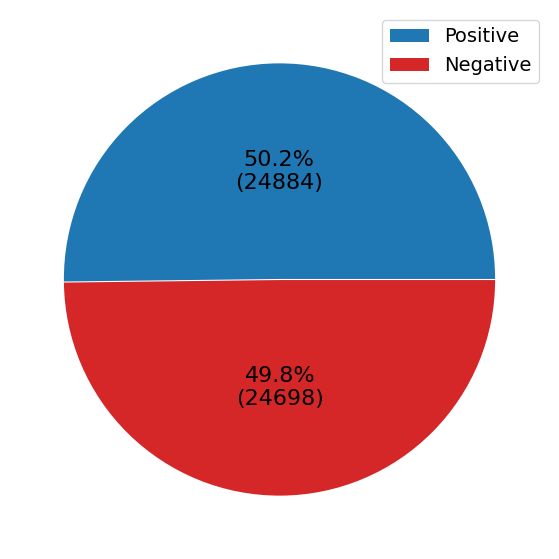

In [40]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def func(pct, allvalues):
    absolute = int(pct/100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]
labels = ['Positive', 'Negative']

# create pie chart
pie, ax = plt.subplots(figsize=(11, 7))
plt.pie(x=data, autopct=lambda pct: func(pct, data), explode=[0.0025]*2, pctdistance=0.5, colors=[sns.color_palette()[0], 'tab:red'], textprops={'fontsize': 16})
labels = [r'Positive', r'Negative']
plt.legend(labels, loc='best', prop={'size': 14})
plt.show()


5788960


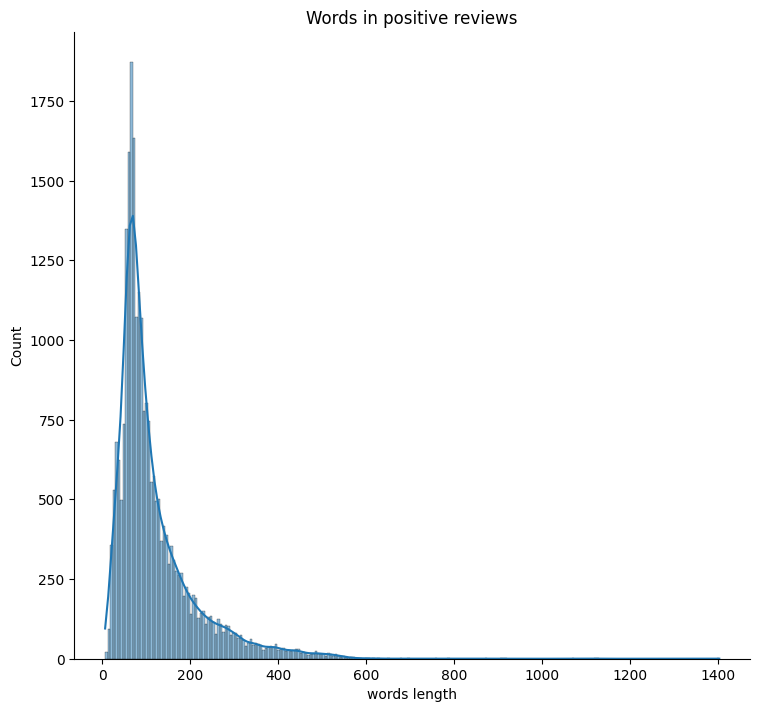

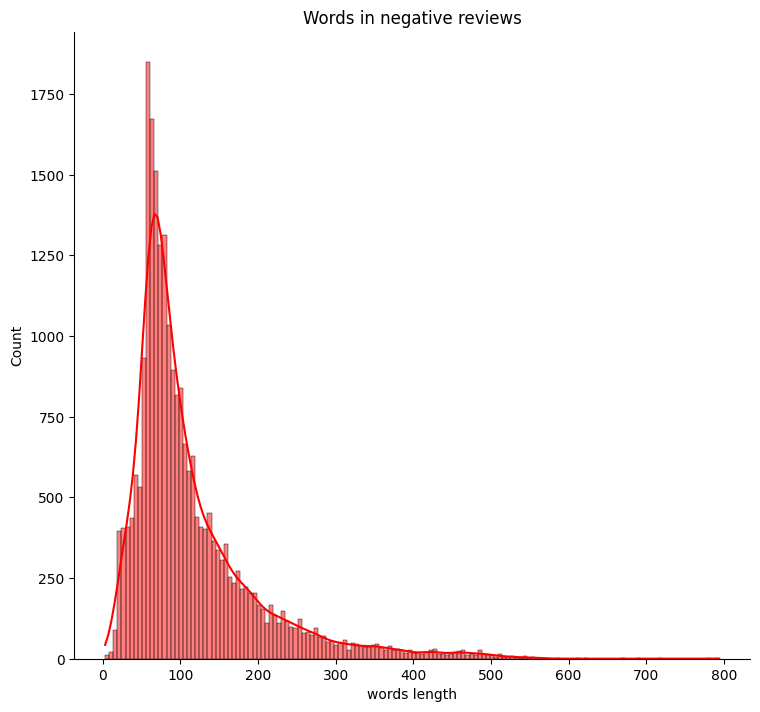

In [42]:

words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words length'] = words_len

hist_possitive = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'],
    x='words length',
    hue='sentiment',
    kde=True,
    height=7,
    aspect=1.1,
    legend=False
).set(title='Words in positive reviews')
plt.show(hist_possitive)

hist_negative = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'negative'],
    x='words length',
    hue='sentiment',
    kde=True,
    height=7,
    aspect=1.1,
    legend=False,
    palette=['red']
).set(title='Words in negative reviews')
plt.show(hist_negative)

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df['sentiment'])

x_train, x_test, y_train, y_test = train_test_split(df['review'], y_data, test_size=0.2, random_state=42)


In [44]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train, y_train)

print(f"Actual vocabulary size: {len(tfidf_vectorizer.get_feature_names_out())}")

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

Actual vocabulary size: 10000


In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

dt_classifier.fit(x_train_encoded, y_train)
y_pred = dt_classifier.predict(x_test_encoded)
print(f'Decision Tree Classifier: {accuracy_score(y_pred, y_test)}')

rf_classifier = RandomForestClassifier(
    random_state=42
)


rf_classifier.fit(x_train_encoded, y_train)
y_pred = rf_classifier.predict(x_test_encoded)
print(f'Random Forest Classifier: {accuracy_score(y_pred, y_test)}')


Decision Tree Classifier: 0.7185640818796006
Random Forest Classifier: 0.8436018957345972
